In [1]:
import pandas as pd
import pandas_datareader.data as web
import numpy as np

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

np.random.seed(1)

get_px = lambda x: web.DataReader(x, 'google', start='2016-08-01', end='2017-07-01')['Close']

symbols = ['SPY','TLT','MSFT', 'ABBV']
data = pd.DataFrame({sym:get_px(sym) for sym in symbols})
lrets = np.log(data/data.shift(1)).dropna()

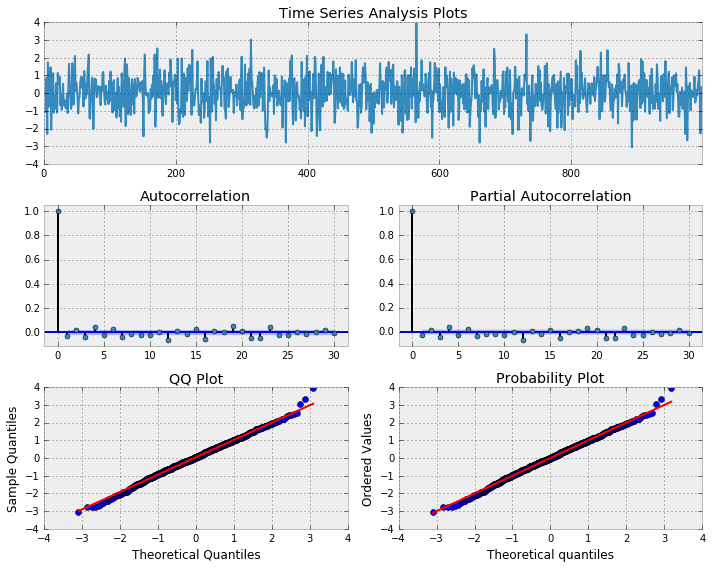

In [2]:
def tsplot(y, lags=None, figsize=(10, 8), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        #mpl.rcParams['font.family'] = 'Ubuntu Mono'
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
        
# plot of discrete white noise
randser = np.random.normal(size=1000)
tsplot(randser, lags=30)

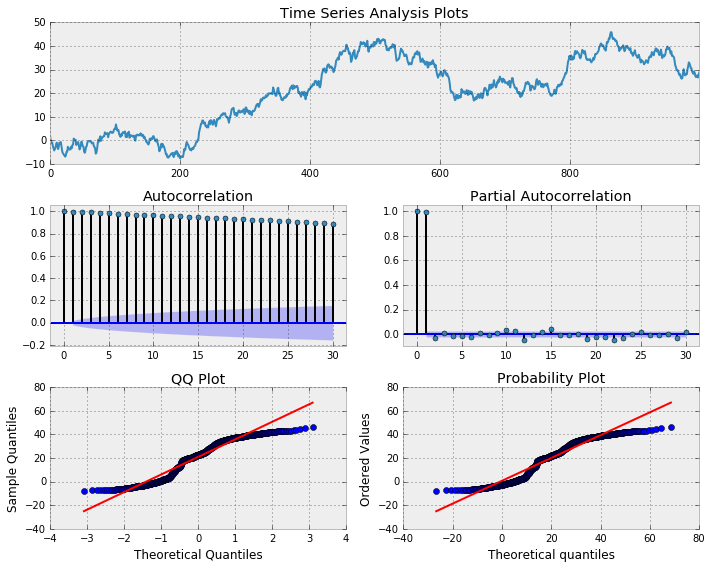

In [3]:
n_samples = 1000
x = w = np.random.normal(size=n_samples)
for t in range(n_samples):
    x[t] = x[t-1] + w[t]
tsplot(x, lags=30)

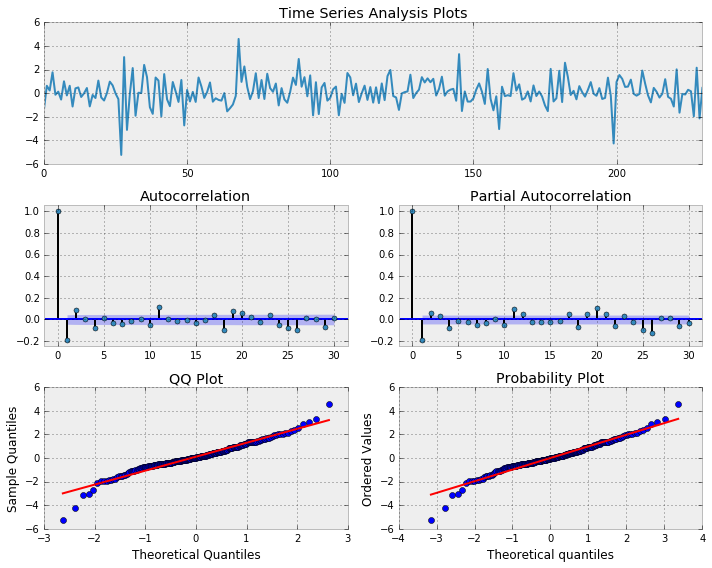

In [4]:
tsplot(np.diff(data.SPY), lags=30)

## Autoregressive Models - AR(p)

In [5]:
n_samples = int(1000)
a = 0.6
x = w = np.random.normal(size=n_samples)
for t in range(n_samples):
    x[t] = a*x[t-1] + w[t]
    
mdl = smt.AR(x).fit(maxlag=30, ic='aic', trend='nc')
est_order = smt.AR(x).select_order(maxlag=30, ic='aic', trend='nc')
true_order = 1
print('alpha estimate: {:3.5f} | best lag order = {}'.format(mdl.params[0], est_order))
print('true alpha = {} | true order = {}'.format(a, true_order))

alpha estimate: 0.58100 | best lag order = 1
true alpha = 0.6 | true order = 1


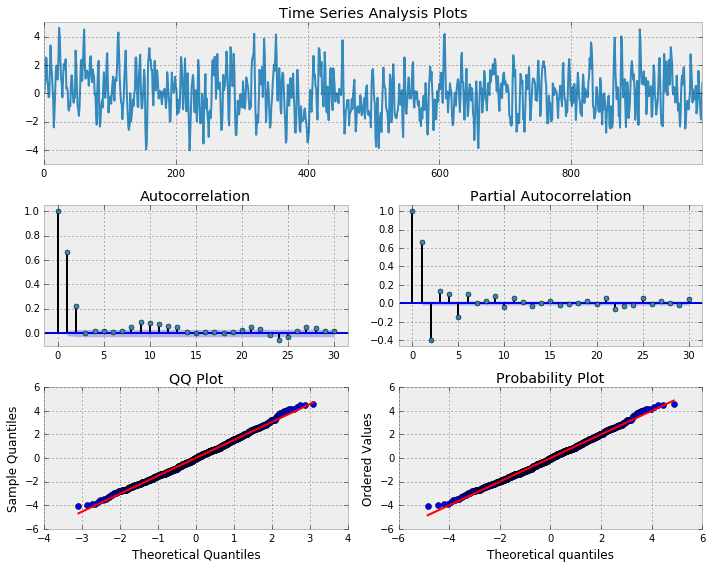

In [6]:
n = int(1000)
alphas = np.array([0])
betas = np.array([1, 0.5])
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]
ar2 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n) 
tsplot(ar2, lags=30)

max_lag = 10
mdl = smt.AR(ar2).fit(maxlag=max_lag, ic='aic', trend='nc')
est_order = smt.AR(ar2).select_order(
    maxlag=max_lag, ic='aic', trend='nc')

true_order = 2
# print('coef estimate: {:3.4f} {:3.4f} | best lag order = {}'.format(mdl.params[0],mdl.params[1], est_order))
# print('true coefs = {} | true order = {}'.format([.666,-.333], true_order))

In [7]:
max_lag = 30
mdl = smt.AR(lrets.MSFT).fit(maxlag=max_lag, ic='aic', trend='nc')
est_order = smt.AR(lrets.MSFT).select_order(maxlag=max_lag, ic='aic', trend='nc')
print('best estimated lag order = {}'.format(est_order))

best estimated lag order = 1


## Moving Average Models - MA(q)

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 1000
Model:                     ARMA(0, 1)   Log Likelihood               -4453.135
Method:                           mle   S.D. of innovations             20.745
Date:                Wed, 02 Aug 2017   AIC                           8910.270
Time:                        00:00:01   BIC                           8920.086
Sample:                             0   HQIC                          8914.001
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1.y        0.9888      0.004    263.292      0.000       0.981       0.996
                                    Roots                                    
                 Real           Imaginary           M

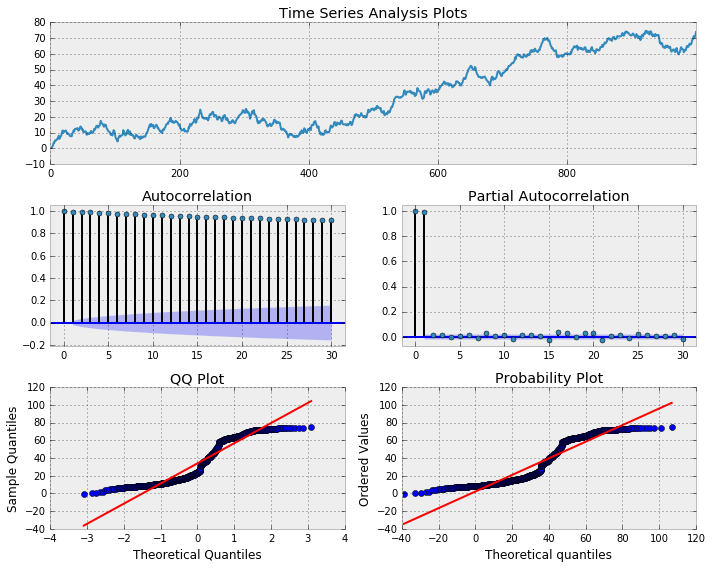

In [8]:
n = int(1000)
alphas = np.array([1])
betas = np.array([0.])
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]
ma1 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n) 
max_lag = 30
mdl = smt.ARMA(ma1, order=(0, 1)).fit(maxlag=max_lag, method='mle', trend='nc')
print(mdl.summary())
tsplot(ma1, lags=30)

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 1000
Model:                     ARMA(0, 3)   Log Likelihood               -1408.322
Method:                           mle   S.D. of innovations              0.989
Date:                Wed, 02 Aug 2017   AIC                           2824.645
Time:                        00:00:02   BIC                           2844.276
Sample:                             0   HQIC                          2832.106
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1.y        0.5686      0.032     18.050      0.000       0.507       0.630
ma.L2.y        0.3400      0.036      9.449      0.000       0.269       0.411
ma.L3.y        0.1234      0.030      4.151      0.0

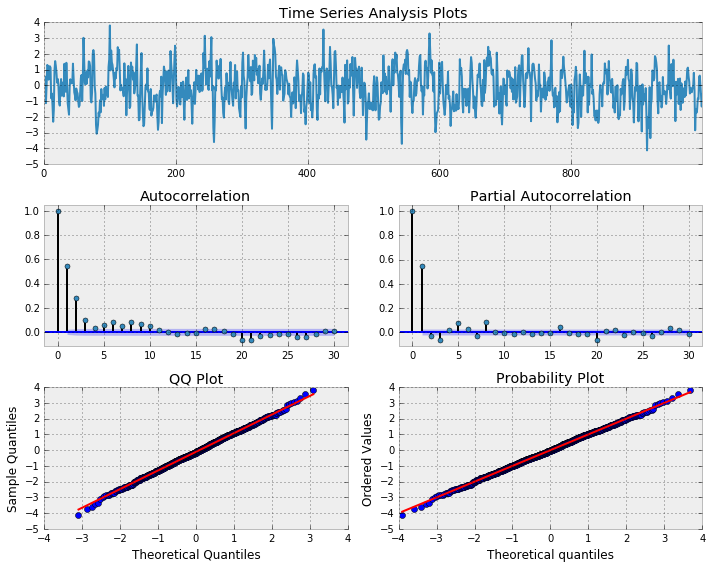

In [9]:
n = int(1000)
alphas = np.array([0.])
betas = np.array([0.6, 0.4, 0.2])
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]
ma3 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n)
max_lag = 30
md3 = smt.ARMA(ma3, order=(0, 3)).fit(maxlag=30, method='mle', trend='nc')
print(md3.summary())
tsplot(ma3, lags=30)

                              ARMA Model Results                              
Dep. Variable:                    SPY   No. Observations:                  231
Model:                     ARMA(0, 3)   Log Likelihood                 887.998
Method:                           mle   S.D. of innovations              0.005
Date:                Wed, 02 Aug 2017   AIC                          -1767.997
Time:                        00:00:03   BIC                          -1754.227
Sample:                    08-02-2016   HQIC                         -1762.443
                         - 06-30-2017                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1.SPY     -0.1680      0.067     -2.517      0.013      -0.299      -0.037
ma.L2.SPY      0.1217      0.071      1.712      0.088      -0.018       0.261
ma.L3.SPY     -0.0224      0.070     -0.319      0.7

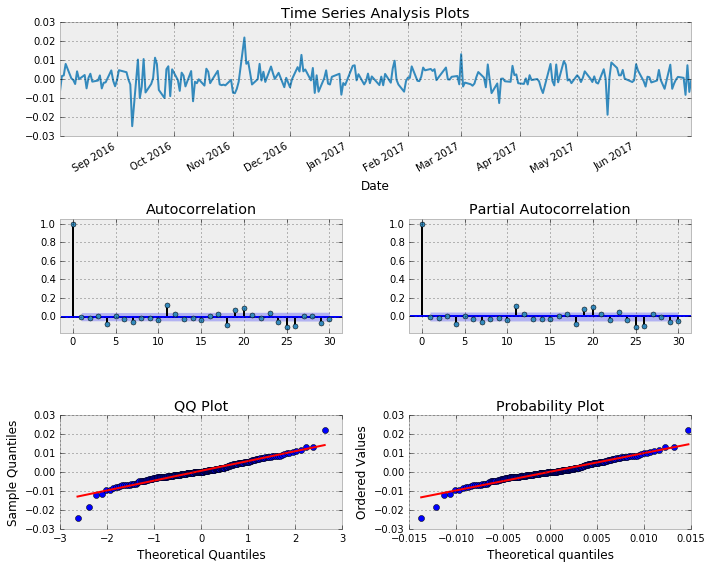

In [10]:
Y = lrets.SPY
md4 = smt.ARMA(Y, order=(0, 3)).fit(maxlag=30, method='mle', trend='nc')
print(md4.summary())
tsplot(md4.resid, lags=30)

## Autoregressive Moving Average Models - ARMA(p, q)

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 5000
Model:                     ARMA(2, 2)   Log Likelihood               -7064.968
Method:                           mle   S.D. of innovations              0.994
Date:                Wed, 02 Aug 2017   AIC                          14139.937
Time:                        00:00:06   BIC                          14172.523
Sample:                             0   HQIC                         14151.358
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1.y        0.4551      0.060      7.628      0.000       0.338       0.572
ar.L2.y       -0.2276      0.015    -14.740      0.000      -0.258      -0.197
ma.L1.y        0.5179      0.061      8.548      0.0

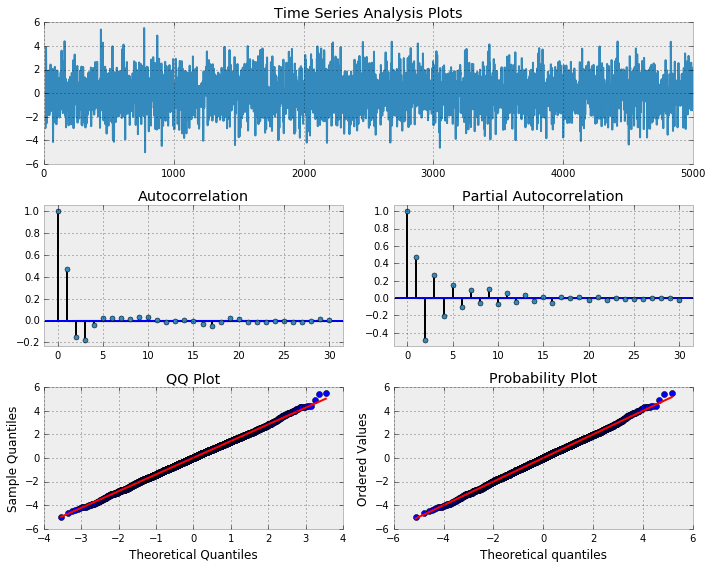

In [11]:
n = int(5000) # lots of samples to help estimates
burn = int(n/10) # number of samples to discard before fit
alphas = np.array([0.5, -0.25])
betas = np.array([0.5, -0.3])
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]
arma22 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n, burnin=burn)
tsplot(arma22, lags=max_lag)
mdl = smt.ARMA(arma22, order=(2, 2)).fit(maxlag=30, method='mle', trend='nc', burnin=burn)
print(mdl.summary())

/usr/local/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


aic: 14233.56057 | order: (3, 2)
                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 5000
Model:                     ARMA(3, 2)   Log Likelihood               -7110.780
Method:                           mle   S.D. of innovations              1.003
Date:                Wed, 02 Aug 2017   AIC                          14233.561
Time:                        00:00:29   BIC                          14272.664
Sample:                             0   HQIC                         14247.266
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1.y        0.5351      0.028     19.321      0.000       0.481       0.589
ar.L2.y       -0.2747      0.016    -17.295      0.000      -0.306      -0.244
ar.L3.y        0.42

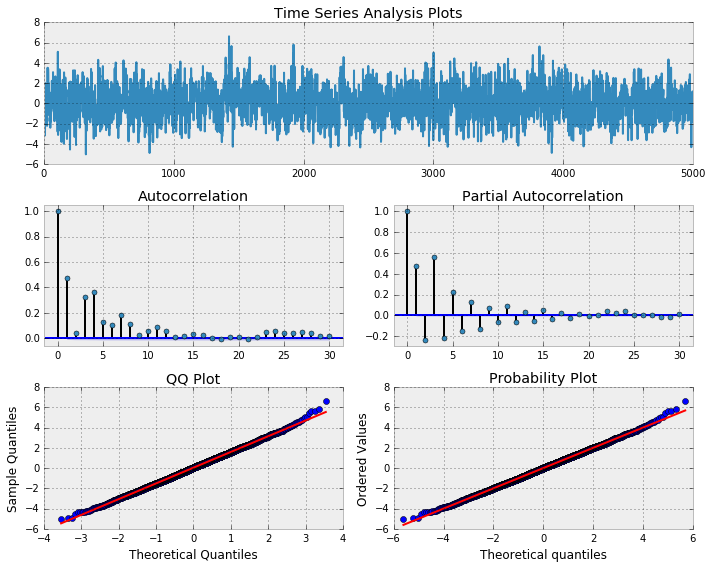

In [12]:
max_lag = 30
n = int(5000)
burn = 2000
alphas = np.array([0.5, -0.25, 0.4])
betas = np.array([0.5, -0.3])
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]
arma32 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n, burnin=burn)
tsplot(arma32, lags=max_lag)


# pick best order by aic 
# smallest aic value wins
best_aic = np.inf 
best_order = None
best_mdl = None

for i in xrange(5):
    for j in xrange(5):
        try:
            tmp_mdl = smt.ARMA(arma32, order=(i, j)).fit(method='mle', trend='nc')
            tmp_aic = tmp_mdl.aic
            if tmp_aic < best_aic:
                best_aic = tmp_aic
                best_order = (i, j)
                best_mdl = tmp_mdl
        except: continue


print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))
print(best_mdl.summary())

In [13]:
best_aic = np.inf 
best_order = None
best_mdl = None

for i in xrange(5):
    for j in xrange(5):
        try:
            tmp_mdl = smt.ARMA(lrets['ABBV'], order=(i, j)).fit(method='mle', trend='nc')
            tmp_aic = tmp_mdl.aic
            if tmp_aic < best_aic:
                best_aic = tmp_aic
                best_order = (i, j)
                best_mdl = tmp_mdl
        except: continue
print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))
print(best_mdl.summary())

/usr/local/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


aic: -1390.72695 | order: (4, 3)
                              ARMA Model Results                              
Dep. Variable:                   ABBV   No. Observations:                  231
Model:                     ARMA(4, 3)   Log Likelihood                 703.363
Method:                           mle   S.D. of innovations              0.012
Date:                Wed, 02 Aug 2017   AIC                          -1390.727
Time:                        00:00:31   BIC                          -1363.188
Sample:                    08-02-2016   HQIC                         -1379.619
                         - 06-30-2017                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1.ABBV     1.3295      0.444      2.992      0.003       0.459       2.200
ar.L2.ABBV    -0.6563      0.718     -0.914      0.362      -2.063       0.751
ar.L3.ABBV     0.11

## Autoregressive Integrated Moving Average Models - ARIMA(p, d, q)

/usr/local/lib/python2.7/site-packages/statsmodels/base/model.py:473: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python2.7/site-packages/statsmodels/tsa/tsatools.py:628: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python2.7/site-packages/statsmodels/tsa/tsatools.py:628: RuntimeWarning: invalid value encountered in divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python2.7/site-packages/statsmodels/tsa/tsatools.py:629: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python2.7/site-packages/statsmodels/tsa/tsatools.py

aic: -1390.72695 | order: (4, 0, 3)
                              ARMA Model Results                              
Dep. Variable:                   ABBV   No. Observations:                  231
Model:                     ARMA(4, 3)   Log Likelihood                 703.363
Method:                           mle   S.D. of innovations              0.012
Date:                Wed, 02 Aug 2017   AIC                          -1390.727
Time:                        00:00:38   BIC                          -1363.188
Sample:                    08-02-2016   HQIC                         -1379.619
                         - 06-30-2017                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1.ABBV     1.3295      0.444      2.992      0.003       0.459       2.200
ar.L2.ABBV    -0.6563      0.718     -0.914      0.362      -2.063       0.751
ar.L3.ABBV     0

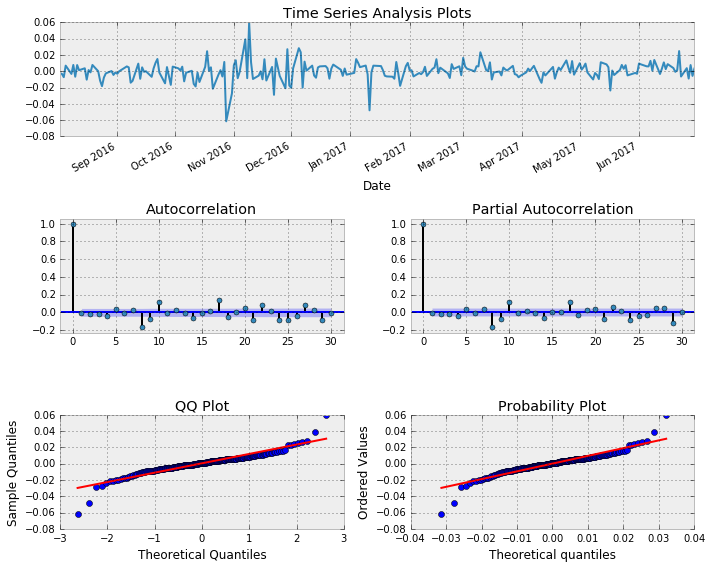

In [14]:
best_aic = np.inf 
best_order = None
best_mdl = None

for i in xrange(5):
    for d in xrange(2):
        for j in xrange(5):
            try:
                tmp_mdl = smt.ARIMA(lrets.ABBV, order=(i,d,j)).fit(method='mle', trend='nc')
                tmp_aic = tmp_mdl.aic
                if tmp_aic < best_aic:
                    best_aic = tmp_aic
                    best_order = (i, d, j)
                    best_mdl = tmp_mdl
            except: continue

print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))
tsplot(best_mdl.resid, lags=30)
print(best_mdl.summary())

In [15]:
n_steps = 21

f, err95, ci95 = best_mdl.forecast(steps=n_steps) # 95% CI
_, err99, ci99 = best_mdl.forecast(steps=n_steps, alpha=0.01) # 99% CI

idx = pd.date_range(data.index[-1], periods=n_steps, freq='D')
fc_95 = pd.DataFrame(np.column_stack([f, ci95]), index=idx, columns=['forecast', 'lower_ci_95', 'upper_ci_95'])
fc_99 = pd.DataFrame(np.column_stack([ci99]), index=idx, columns=['lower_ci_99', 'upper_ci_99'])
fc_all = fc_95.combine_first(fc_99)
fc_all.head()

,forecast,lower_ci_95,lower_ci_99,upper_ci_95,upper_ci_99
2017-06-30,-0.000261,-0.022803,-0.029887,0.022282,0.029366
2017-07-01,-0.001800,-0.024346,-0.031431,0.020746,0.027831
2017-07-02,-0.000317,-0.022951,-0.030063,0.022316,0.029428
2017-07-03,0.000640,-0.022297,-0.029504,0.023577,0.030784
2017-07-04,0.000916,-0.022056,-0.029275,0.023889,0.031107


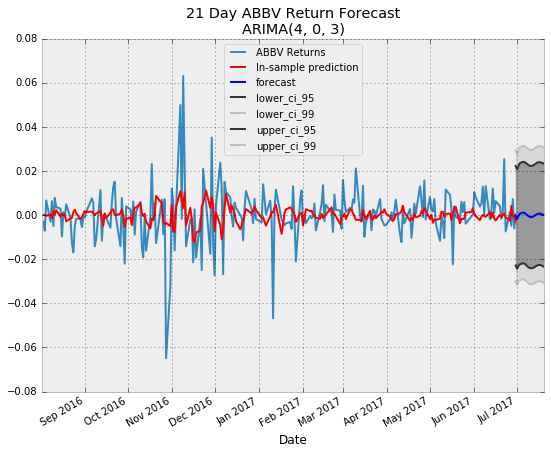

In [16]:
plt.style.use('bmh')
fig = plt.figure(figsize=(9,7))
ax = plt.gca()

ts = lrets.ABBV.copy()
ts.plot(ax=ax, label='ABBV Returns')
# in sample prediction
pred = best_mdl.predict(ts.index[0], ts.index[-1])
pred.plot(ax=ax, style='r-', label='In-sample prediction')

styles = ['b-', '0.2', '0.75', '0.2', '0.75']
fc_all.plot(ax=ax, style=styles)
plt.fill_between(fc_all.index, fc_all.lower_ci_95, fc_all.upper_ci_95, color='gray', alpha=0.7)
plt.fill_between(fc_all.index, fc_all.lower_ci_99, fc_all.upper_ci_99, color='gray', alpha=0.2)
plt.title('{} Day ABBV Return Forecast\nARIMA{}'.format(n_steps, best_order))
plt.legend(loc='best', fontsize=10)